<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/MI/IMSc_Lab_PGM_Structure_Learning_Handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

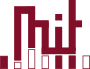 Mesterséges Intelligencia és Rendszertervezés Tanszék, ©2024. BME-MIT, Sándor Dániel  
# **VIMIAC16 - Mesterséges Intelligencia**
## 2024. Őszi félév
## **iMSc Laborgyakorlat** **- Valószínűségi hálók+**

# Oksági felfedezés valószínűségi gráfos modellekben

Ahogy a korábbi gyakorlaton láthattuk a Bayes-hálók leegyszerűsítik változók közötti függetlenségek vizuális megjelenítését és a következtetést, ezért jól használhatók különböző szakterületek modellezésére. A struktúrájuk (gráf éleinek megléte és iránya) meghatározható szakértők által (lásd előző gyakorlat), de gyakori, hogy adatokból akarjuk adott feltevések mellett visszakapni az adatot generáló DAG struktúrát, ez utóbbit nevezzük struktúra tanulásnak vagy oksági felfedezésnek.

Ezen a gyakorlaton a [Sachs adathalmazt](http://www.esalq.usp.br/lepse/imgs/conteudo_thumb/Causal-Protein-Signaling-Networks-Derived-from-Multiparameter-Single-Cell-Data.pdf) fogjuk használni. Ez proteinek közötti jelzéseket tartalmaz, kísérletekkel megerősített referencia struktúrával. A mérések cytometriai adatokat tartalmaznak, a különböző molekulák relatív megjelenésére különböző perturbációk hatására.

Elsőként futtassuk az alábbi 5 cellát a gráf betöltéséig!

## Setup

In [1]:
! pip install pgmpy --quiet
! pip install cdt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 12.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid
from sklearn.metrics import mutual_info_score

import pgmpy
from pgmpy.estimators import BicScore
from cdt.data import load_dataset
import networkx as nx

np.random.seed(123)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
s_data, s_graph = load_dataset('sachs')
s_graph.remove_edge('PIP2', 'PIP3')
s_graph.add_edge('PIP3', 'PIP2')

In [4]:
N_BINS = 4
discrete_s_data = s_data.copy()
for c in s_data.columns:
  discrete_s_data[c] = pd.cut(x=discrete_s_data[c], bins=[np.nanquantile(discrete_s_data[c], (1/N_BINS)*i)  if i!=0 else 0 for i in range(N_BINS+1)],
                     labels=[0,1,2,3])

## 0. Feladat



Ismerkedjünk meg az alábbi gráffal!

Opcionálisan: Próbáljunk 1-2 interakciókat igazolni forrásokkal! Miben játszanak szerepet a vizsgált proteinek? Van olyan interakció, amelyet nem sikerült igazolni pár kereséssel?


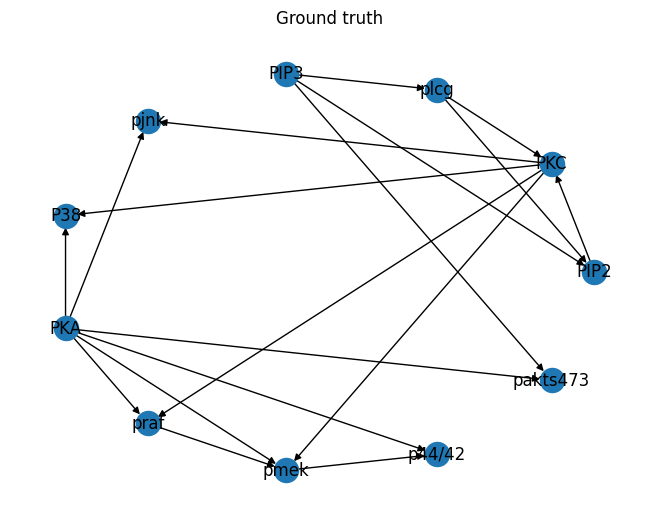

In [5]:
nx.draw(s_graph, pos=nx.circular_layout(s_graph), with_labels=True)
plt.title('Ground truth')
plt.show()

## 1. Feladat: Kölcsönös információ-alapú összefüggések



Készítsünk egy baseline módszert, amellyel ugyan DAG-ot nem tudunk kapni, de egy irányítatlan gráfstruktúrával közelítsük a valós gráfot! Ehhez a változókra páronként számoljuk ki a kölcsönös információt egy mátrixba (`mutual_info_score`)!  Majd válasszunk egy olyan küszöbértéket, amellyel elvágva egy "hihető" összefüggési gráfot kapunk! A második cellával plotoljuk és vizsgáljuk meg a kapott struktúrát! Miben egyezik és miben tér el az eredetitől?

A kölcsönös információ képlete:

$I(X,Y) = H(X) - H(X|Y)$

In [6]:
data = discrete_s_data.to_numpy()
mut_infos = np.zeros((data.shape[1],data.shape[1]))

# TODO: páronkénti kölcsönös információ számítása
for i in range(data.shape[1]):
  for j in range(data.shape[1]):
    mut_infos[i,j] = mutual_info_score(data[:,i], data[:,j])

threshold = 0.05 # TODO: küszöb érték meghatározása
mut_infos[mut_infos < threshold] = 0

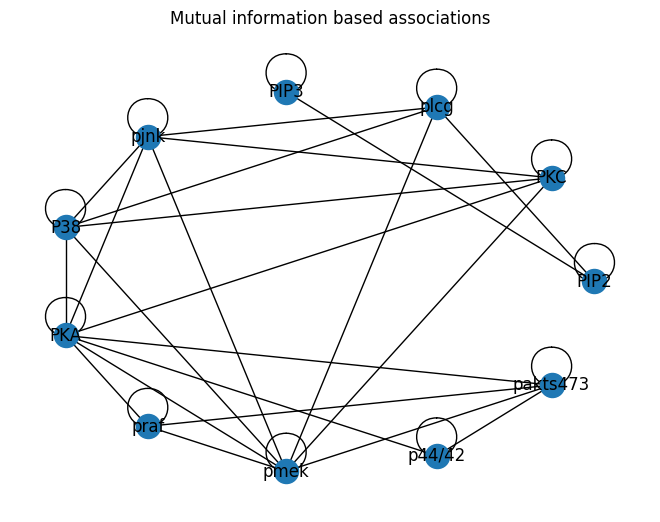

In [7]:
nx_graph_mut_info = nx.from_numpy_array(mut_infos)
nx_graph_mut_info = nx.relabel_nodes(nx_graph_mut_info, {a:b for (a,b) in zip(range(data.shape[1]), s_data.columns)})
nx.draw(nx_graph_mut_info, pos=nx.circular_layout(s_graph), with_labels=True)
plt.title('Mutual information based associations')
plt.show()

## 2. Feladat: Score-alapú diszkrét keresés




A diszkrét keresés lényege, hogy DAG állapotok között oly módon lépkedünk, hogy lehetőleg egyre jobban illeszkedjen az adatunkhoz. Számos keresési módszer áll rendelkezésünkre, most a választott a valószínűségi alapú hegymászás (Probabilistic Hill Climb) lesz. Ehhez minden lépésben legeneráljuk a lehetséges szomszédokat, majd kiszámoljuk rájuk a score-beli különbséget és ezzel arányos valószínűség alapján választjuk ki a következő állapotot.

### 2.1 Szomszédos DAG-ok felsorolása

Szomszédosnak tekintünk most két DAG állapotot, ha azok csak egy élben térnek el (hozzáadás elvétel vagy megfordítás). Első lépésként állítsuk elő a lehetséges szomszédokat! Ehhez az él felvételt és eltávolítást megírtuk előre, most egészítsük ki a megfordítással! Az első két függvényhez hasonlóan a ```potential_edges_to_flip``` függvény is egy dicitionary-vel térjen vissza, amelynek kulcsa a megfordítandó él és értéke a scoreok különbözete (Vigyázzunk, itt két node szülei is változnak).


In [8]:
def potential_edges_to_add(model, data, score):
  pot_edges = {}
  for u in model.nodes():
    for v in model.nodes():
      if((u,v) not in model.edges() and not nx.has_path(model, v, u)):
        old_parents = model.get_parents(v)
        new_parents = model.get_parents(v)+[u]
        pot_edges[(u,v)] = score(v, new_parents) - score(v, old_parents)
  return pot_edges

def potential_edges_to_remove(model, data, score):
  pot_edges = {}
  for u,v in model.edges():
    old_parents = model.get_parents(v)
    new_parents = [p for p in model.get_parents(v) if p != u]
    pot_edges[(u,v)] = score(v, new_parents) - score(v, old_parents)
  return pot_edges

def potential_edges_to_flip(model, data, score):
  # TODO: Megfordítható élek dicitionary-ben felsorolva
  pot_edges = {}
  for u,v in model.edges():
    if(not np.any(nx.has_path(model, u, p) for p in model.get_parents(v))):
      old_parents_v = model.get_parents(v)
      old_parents_u = model.get_parents(u)
      new_parents_v = [p for p in model.get_parents(v) if p != u]
      new_parents_u = model.get_parents(u)+[v]
      pot_edges[(u,v)] = score(v, new_parents_v) - score(v, old_parents_v) + score(u, new_parents_u) - score(u, old_parents_u)
  return pot_edges


def generate_potential_actions(model, data, score):
  pot_add = potential_edges_to_add(model, data, score)
  pot_rem = potential_edges_to_remove(model, data, score)
  pot_flip = potential_edges_to_flip(model, data, score)

  pot_actions = []

  for ka in pot_add.keys():
    pot_actions.append(('add', ka, pot_add[ka]))
  for kr in pot_rem.keys():
    pot_actions.append(('remove', kr, pot_rem[kr]))
  for kf in pot_flip.keys():
    pot_actions.append(('flip', kf, pot_flip[kf]))

  return pot_actions


### 2.2 Algoritmus összeállítása

A keresés egy üres DAG-ból indul. Majd konvergenciáig legeneráljuk a létező akciókat, a fenti `generate_potential_actions` függvénnyel. Ez tripletek listáját adja vissza: (akció, él, score különbség) formában. Ezeket mintavételezzük a score-al arányos valószínűségekkel és végezzük el a lépést, ehhez használjuk a `np.random.choice` függvényt. Az algoritmus álljon le, ha már epsilonnál kisebb scorekülönbséget választanánk és térjen vissza a `model`-el!

In [13]:
def hill_climb(df_data, score, iters, eps):
  model = pgmpy.base.DAG()
  model.add_nodes_from(df_data.columns)
  for i in range(iters):

    # akciók legenerálása
    potential_actions = generate_potential_actions(model, df_data, score)

    # akció választás
    scores = np.array([s if s > 0 else 0 for (_,_,s) in potential_actions])
    if(np.all(np.array(scores) < eps)):
      print(f'Iter {i}: Ended')
      break
    probs = scores/np.sum(scores)
    idx = np.random.choice(len(potential_actions), size=1, p=probs)[0]
    chosen_action = potential_actions[idx]

    u, v = chosen_action[1]
    # akció végehajtása
    if (chosen_action[0] == 'add'):
      print(f'Iter {i}: Added {chosen_action[1]}')
      model.add_edge(u, v)
    elif(chosen_action[0] == 'remove'):
      print(f'Iter {i}: Removed {chosen_action[1]}')
      model.remove_edge(u, v)
    elif(chosen_action[0] == 'flip'):
      print(f'Iter {i}: Flipped {chosen_action[1]}')
      model.add_edge(v, u)
  return model

### 2.3 Futtassuk az algoritmust

Válasszuk a Bayesian Information Criterion (BIC) score függvényt a pgmpy [dokumentációból](https://pgmpy.org/structure_estimator/hill.html#structure-score) és próbáljuk ki az algoritmust. Ne feledjük, ez többsége diszkrét változókon működik, ezért használjuk a diszkretizált `discrete_s_data` dataframe-et.

In [14]:
score_fn = pgmpy.estimators.BicScore(discrete_s_data).local_score
model = hill_climb(discrete_s_data, score_fn, 100, 0.00001)

Iter 0: Added ('PKC', 'praf')
Iter 1: Added ('plcg', 'PKA')
Iter 2: Added ('plcg', 'praf')
Iter 3: Added ('pakts473', 'p44/42')
Iter 4: Added ('PKC', 'P38')
Iter 5: Added ('PIP2', 'plcg')
Iter 6: Added ('pjnk', 'PKC')
Iter 7: Added ('PKA', 'pmek')
Iter 8: Added ('PIP2', 'pjnk')
Iter 9: Added ('plcg', 'PIP3')
Iter 10: Added ('pmek', 'PKC')
Iter 11: Added ('PKA', 'p44/42')
Iter 12: Added ('PIP2', 'PIP3')
Iter 13: Added ('pmek', 'praf')
Iter 14: Added ('pakts473', 'pmek')
Iter 15: Added ('pjnk', 'pakts473')
Iter 16: Added ('PIP2', 'pakts473')
Iter 17: Added ('PIP3', 'pjnk')
Iter 18: Added ('PKA', 'P38')
Iter 19: Added ('pjnk', 'PKA')
Iter 20: Removed ('plcg', 'praf')
Iter 21: Added ('PKA', 'pakts473')
Iter 22: Removed ('pjnk', 'pakts473')
Iter 23: Removed ('PKC', 'praf')
Iter 24: Added ('pjnk', 'P38')
Iter 25: Removed ('PKA', 'P38')
Iter 26: Added ('pjnk', 'praf')
Iter 27: Ended


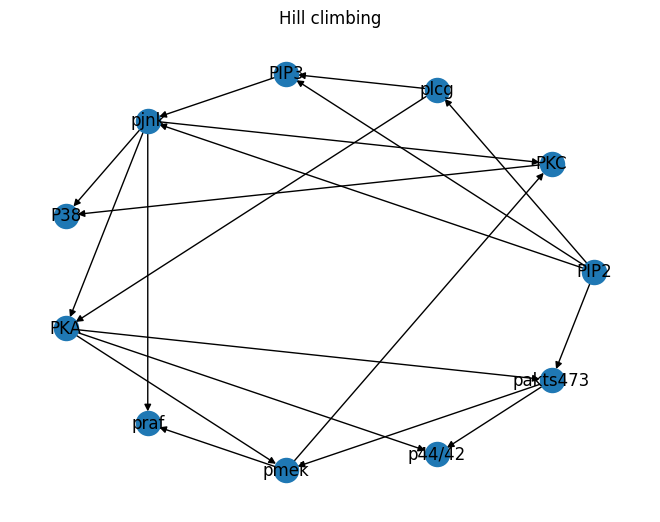

In [15]:
nx_graph_hill_climb = nx.DiGraph(model.edges())
nx.draw(nx_graph_hill_climb, pos=nx.circular_layout(s_graph), with_labels=True)
plt.title('Hill climbing')
plt.show()

## 3. Feladat kiértékelés

### 3.1 Metrikák definiálása

Gyors és szemléletes kiértékeléshez használjuk a Strukturális Hamming Távolságot (SHD), amely a hiányzó, hamisan behúzott és fordítva behúzott élek összege. Három esetre definiáltuk: irányított, irányítatlan és részben irányított gráfokra.

Egészítsük ki a `directed_shd` függvényt az `undirected_shd` mintájára. Figyeljünk arra, hogy itt számít az élek iránya!

In [16]:
def directed_shd(pred_edges, truth_edges):
  shd = 0
  for (a,b) in truth_edges:
    if (a,b) not in pred_edges:
      shd += 1
  for (a,b) in pred_edges:
    if (a,b) not in truth_edges:
      shd += 1
  pass

def undirected_shd(pred_edges, truth_edges):
  shd = 0
  for (a,b) in truth_edges:
    if (a,b) not in pred_edges and (b,a) not in pred_edges :
      shd += 1
  for (a,b) in pred_edges:
    if (a,b) not in truth_edges and (b,a) not in truth_edges:
      shd += 1
  return shd

def partial_shd(pred_directed, truth_directed, pred_undirected, truth_undirected):
  d = directed_shd(pred_directed, truth_directed)
  u = undirected_shd(pred_undirected, truth_undirected)
  return d + u


### 3.2 Markov ekvivalencia osztály meghatározása

A struktúratanulás megfigyelt adatokból jellemzően nem képes a teljes DAG-ot rekonstruálni, csupán a Markov-ekvivalencia osztály erejéig. A kiértékeléshez tehát szükség van a megtalált ekvivalencia osztályok összehasonlíthatóságára. Ehhez futtassuk a `create_pdag` függvényt!

A függvény először megalkotja a skeletont, azaz a létező éleket, amelyek alap esetben irányítatlanok. Ezután az ütköző V struktúrákat azonosítja (ezek biztosan irányítottak). Majd a [4 Meek szabály](https://arxiv.org/ftp/arxiv/papers/1302/1302.4972.pdf) sorbani alkalmazásával megirányítja a lehetséges éleket.

In [17]:
def create_pdag(dag):
  dag = pgmpy.base.DAG(dag)

  # skeleton
  skeleton = list(dag.edges())
  skeleton.extend([(b, a) for (a,b) in skeleton])
  directed = []

  # immoralities
  immoralities = dag.get_immoralities()

  for (a, b) in immoralities:
    a_children = set(dag.get_children(a))
    b_children = set(dag.get_children(b))
    common_children = list(a_children.intersection(b_children))
    a_edges = [(a, c) for c in common_children]
    b_edges = [(b, c) for c in common_children]
    directed.extend(a_edges)
    directed.extend(b_edges)

  # meek rules
  next_dag = pgmpy.base.DAG()
  next_dag.add_nodes_from(dag.nodes())
  next_dag.add_edges_from(directed)
  previous_dag = None

  while next_dag != previous_dag:
    previous_dag = next_dag
    # 1
    for (a, b) in skeleton:
      if (a, b) in next_dag.edges() or (b, a) in next_dag.edges():
        continue
      if np.all([(c, b) not in skeleton for c in next_dag.get_parents(a)]):
        next_dag.add_edge(a,b)

    # 2
    for (a, b) in skeleton:
      if (a, b) in next_dag.edges() or (b, a) in next_dag.edges():
        continue
      if nx.has_path(next_dag, a, b):
        next_dag.add_edge(a,b)
    # 3
    for (a, b) in skeleton:
      if (a, b) in next_dag.edges() or (b, a) in next_dag.edges():
        continue
      for (i1, i2) in next_dag.get_immoralities():
        if i1 in next_dag.get_parents(b) and i2 in next_dag.get_parents(b) and (a, i1) in skeleton and (a, i2) in skeleton:
          next_dag.add_edge(a,b)
    #4
    for (a, b) in skeleton:
      if (a, b) in next_dag.edges() or (b, a) in next_dag.edges():
        continue
      for pa_b in next_dag.get_parents(b):
        if (pa_b,a) in skeleton:
          for pa_pa_b in next_dag.get_parents(pa_b):
            if (pa_pa_b, a) in skeleton:
              next_dag.add_edge(a,b)
              break

  directed.extend(list(next_dag.edges()))

  undirected = []
  for (a,b) in skeleton:
    if (a,b) not in undirected and (b,a) not in undirected:
      if (a,b) not in directed and (b,a) not in directed:
        undirected.append((a,b))


  pdag = pgmpy.base.PDAG(directed_ebunch=directed,
                         undirected_ebunch=undirected)

  return pdag

### 3.3 Gráfok értékelése

Futtassuk le a kiértékelést és értékeljük a kapott eredményeket és válaszoljunk a kérdésekre!
- Melyik módszer közelíti legjobban a valós gráfot?
- Mi garantálja az egyes módszerekben, hogy a kapott gráf DAG?


In [18]:
true_dag = s_graph
true_pdag = create_pdag(s_graph)

# Mut-info graph
mut_info_undirected_shd = undirected_shd(nx_graph_mut_info.edges(), true_dag.edges())
print(f'Hill climb undirected shd: {mut_info_undirected_shd}')

# Hill climb graph
hill_directed_shd = directed_shd(nx_graph_hill_climb.edges(), true_dag.edges())
hill_undirected_shd = undirected_shd(nx_graph_hill_climb.edges(), true_dag.edges())

hill_pdag = create_pdag(nx_graph_hill_climb)
hill_partial_shd = partial_shd(hill_pdag.directed_edges, true_pdag.directed_edges,
                    hill_pdag.undirected_edges, true_pdag.undirected_edges)

print(f'Hill climb directed shd: {hill_directed_shd}, undirected shd: {hill_undirected_shd}, partially directed shd: {hill_partial_shd}')


Hill climb undirected shd: 27


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [ ]:
nx.draw_networkx_nodes(true_pdag, pos=nx.circular_layout(s_graph))
nx.draw_networkx_labels(true_pdag, pos=nx.circular_layout(s_graph))
nx.draw_networkx_edges(true_pdag, pos=nx.circular_layout(s_graph), edgelist=true_pdag.directed_edges)
nx.draw_networkx_edges(true_pdag, pos=nx.circular_layout(s_graph), edgelist=true_pdag.undirected_edges, arrows=False)
plt.title('True PDAG')
plt.show()

In [ ]:
nx.draw_networkx_nodes(hill_pdag, pos=nx.circular_layout(s_graph))
nx.draw_networkx_labels(hill_pdag, pos=nx.circular_layout(s_graph))
nx.draw_networkx_edges(hill_pdag, pos=nx.circular_layout(s_graph), edgelist=hill_pdag.directed_edges)
nx.draw_networkx_edges(hill_pdag, pos=nx.circular_layout(s_graph), edgelist=hill_pdag.undirected_edges, arrows=False)
plt.title('Hill Climb PDAG')
plt.show()